In [1]:
import tensorflow as tf
import json
import matplotlib.image as mpimg
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import heapq

import operator

from tensorflow.contrib.tensorboard.plugins import projector

%matplotlib inline

print("running TensorFlow version {}".format(tf.__version__))

running TensorFlow version 1.8.0-dev20180330


In [2]:
RANDOM_SEED = 42
SUBSET = "validate"

LOG_ROOT = '../../data/'

RUN_NAME = 'vae/vae_001'
SUMMARY_DIR = os.path.join(LOG_ROOT, 'logs', RUN_NAME)

EXPT_NAME = 'expt_001'
VIS_NAME = 'vis_001'
DATA_ROOT = '/var/data/processed'
ORIGINAL_DATA_ROOT = '/var/data/original'

EXPT_DIR = os.path.join(DATA_ROOT, EXPT_NAME, 'data')
TFRECORDS_DIR = os.path.join(EXPT_DIR, 'tfrecords')
EMBEDDINGS_DIR = os.path.join(EXPT_DIR, 'embeddings')
ENCODED_IMAGES_DIR =  os.path.join(EXPT_DIR, 'images')
ORIGINAL_IMAGES_DIR = os.path.join(ORIGINAL_DATA_ROOT, 'data', 'images')

VIS_DIR = os.path.join(EXPT_DIR,'visualisations',VIS_NAME)
SPRITE_DIR = os.path.join(VIS_DIR, 'sprite.png')
META_DIR =  os.path.join(VIS_DIR, 'metadata.tsv')


In [3]:
documents = []
json_files = [pos_json for pos_json in os.listdir(EMBEDDINGS_DIR) if pos_json.endswith('.json')]
for file in json_files:
    path = os.path.join(EMBEDDINGS_DIR, file)
    with open(path) as f:
        doc = json.load(f)
        if (doc['subset'] == SUBSET):
            documents.append(doc)


for doc in documents:
    doc['mu'] = np.asarray(doc['mu'])
    doc['sigma'] = np.asarray(doc['sigma'])
    doc['labels'] = np.asarray(doc['labels'])

# Examine images

In [36]:
def show_image(img):
    plt.imshow(img,  cmap='gray')
    plt.show()

In [37]:
from collections import OrderedDict
LABEL_KEYS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "No Finding",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
]

label_keys_by_id = LABEL_KEYS
ids_by_label_key = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id)])
  
def getlabels(doc):
    list = []
    for index_value, index in enumerate(doc['labels']):
        if(index == 1):
            list.append(ids_by_label_key.get(index_value))

    return list

In [38]:
from collections import OrderedDict
LABEL_KEYS_SHORT = [
    "Ats",
    "Ca",
    "Co",
    "Ed",
    "Ef",
    "Em",
    "Fi",
    "He",
    "In",
    "Ma",
    "No",
    "No",
    "Pl",
    "Pn",
    "Px"
]

label_keys_by_id2 = LABEL_KEYS_SHORT
ids_by_label_key2 = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id2)])

def getlabels_short(doc):
    list = []
    for index_value, index in enumerate(doc['labels']):
        if(index == 1):
            list.append(ids_by_label_key2.get(index_value)[:2])
            
    return list

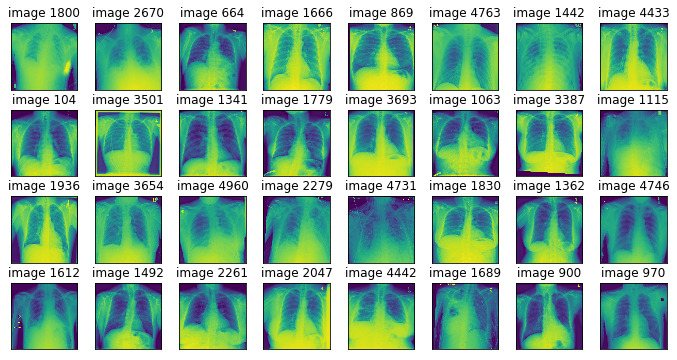

In [39]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, doc in zip(axes.flat, documents[:32]):
    ax.set_title("image {}".format(doc['id']))
    path = os.path.join(ORIGINAL_IMAGES_DIR, doc['filename'])
    img = mpimg.imread(path)
    ax.imshow(img)

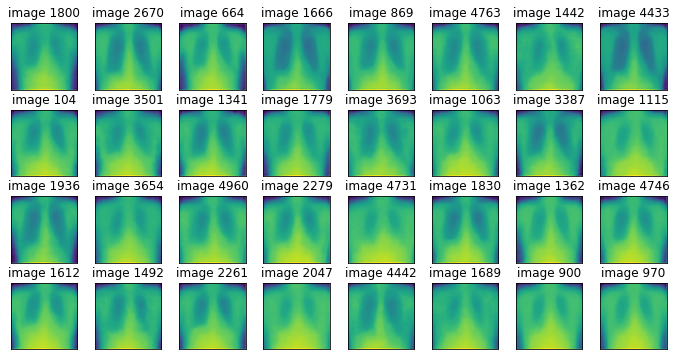

In [40]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, doc in zip(axes.flat, documents[:32]):
    ax.set_title("image {}".format(doc['id']))
    path = os.path.join(ENCODED_IMAGES_DIR, doc['encodedname'])
    img=mpimg.imread(path)
    ax.imshow(img)

# Do some example searches

## KL divergence-based distance

In [44]:
def kl(xbar, xsigma, ybar, ysigma):
    ''' KL(x||y)
    '''
    xvar = xsigma**2
    yvar = ysigma**2
    
    return 0.5*np.sum((xvar+(xbar-ybar)**2)/yvar - 1 + np.log(yvar/xvar))

In [45]:
kl_matrix = np.zeros((len(documents), len(documents)))

for k, d1 in enumerate(documents):
    for d2 in documents:
        kl_matrix[d1['id'], d2['id']] = kl(d2['mu'], d2['sigma'], d1['mu'], d1['sigma'])
    if not (k+1)%24:
        print('.', end='', flush=True)
print('done')

.....................................................................................................................................................................................................................done


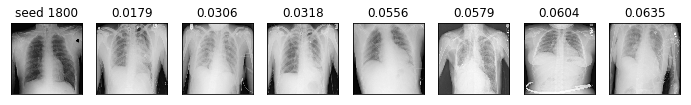

seed(1800) labels: ['No Finding']
doc(2961) labels: ['Effusion', 'Pneumothorax']
doc(3470) labels: ['Infiltration', 'Mass']
doc(1512) labels: ['Pneumothorax']
doc(4861) labels: ['No Finding']
doc(5075) labels: ['Consolidation', 'Effusion', 'Infiltration', 'Nodule']
doc(2330) labels: ['No Finding']
doc(2029) labels: ['No Finding']


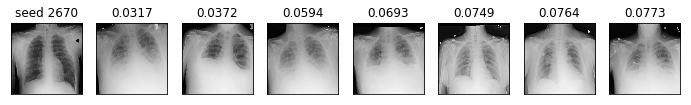

seed(2670) labels: ['Atelectasis', 'Effusion', 'Infiltration']
doc(3045) labels: ['Effusion']
doc(2742) labels: ['No Finding']
doc(3009) labels: ['Atelectasis', 'Consolidation']
doc(2934) labels: ['No Finding']
doc(3706) labels: ['No Finding']
doc(4132) labels: ['No Finding']
doc(2865) labels: ['No Finding']


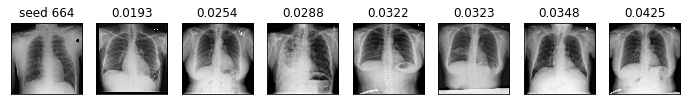

seed(664) labels: ['Atelectasis']
doc(3740) labels: ['Cardiomegaly']
doc(2174) labels: ['No Finding']
doc(1259) labels: ['Atelectasis', 'Mass']
doc(2120) labels: ['No Finding']
doc(258) labels: ['Mass']
doc(484) labels: ['Edema', 'Infiltration']
doc(4977) labels: ['No Finding']


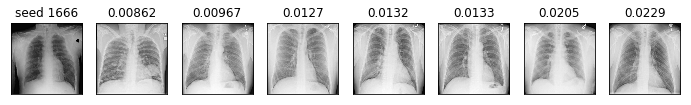

seed(1666) labels: ['No Finding']
doc(1415) labels: ['No Finding']
doc(748) labels: ['No Finding']
doc(3390) labels: ['No Finding']
doc(3680) labels: ['No Finding']
doc(1897) labels: ['Edema', 'Effusion']
doc(4267) labels: ['No Finding']
doc(1766) labels: ['Nodule']


In [46]:
for seed in documents[:4]:
    def score(doc):
        if doc['id'] == seed['id']:
            return np.inf
        else:
            return kl_matrix[seed['id'], doc['id']]

    results = heapq.nsmallest(7, documents, key=score)
    
    fig, axes = plt.subplots(1, 8, figsize=(12, 2), subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0].set_title("seed {}".format(seed['id']))
    path = os.path.join(ORIGINAL_IMAGES_DIR, doc['filename'])
    img = mpimg.imread(path)
    axes[0].imshow(img, cmap='gray')
    
    labels = []
    labels.append("seed({}) labels: {}".format(seed['id'], getlabels(seed)))
    
    for k in range(1, len(axes)):
        axes[k].set_title("{:.3g}".format(score(results[k-1])))
        path = os.path.join(ORIGINAL_IMAGES_DIR, results[k-1]['filename'])
        img = mpimg.imread(path)
        axes[k].imshow(img, cmap='gray')
        
    for i,result in enumerate(results): 
        labels.append("doc({}) labels: {}".format(result['id'], getlabels(result)))
        
    plt.show()
    
    for label in labels:
        print(label)


## Sum of squares distance


In [47]:
def distance(a, b):
    return 0.5*np.sum((a-b)**2)

In [48]:
distance_matrix = np.zeros((len(documents), len(documents)))

for k, d1 in enumerate(documents):
    for d2 in documents:
        distance_matrix[d1['id'], d2['id']] = distance(d1['mu'], d2['mu'])
        
    if not (k+1)%24:
        print(',', end='', flush=True)
print("done")

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,done


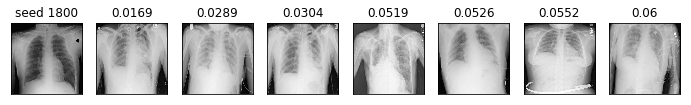

seed(1800) labels: ['No Finding']
doc(2961) labels: ['Effusion', 'Pneumothorax']
doc(3470) labels: ['Infiltration', 'Mass']
doc(1512) labels: ['Pneumothorax']
doc(5075) labels: ['Consolidation', 'Effusion', 'Infiltration', 'Nodule']
doc(4861) labels: ['No Finding']
doc(2330) labels: ['No Finding']
doc(2029) labels: ['No Finding']


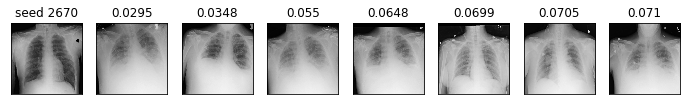

seed(2670) labels: ['Atelectasis', 'Effusion', 'Infiltration']
doc(3045) labels: ['Effusion']
doc(2742) labels: ['No Finding']
doc(3009) labels: ['Atelectasis', 'Consolidation']
doc(2934) labels: ['No Finding']
doc(3706) labels: ['No Finding']
doc(4132) labels: ['No Finding']
doc(2865) labels: ['No Finding']


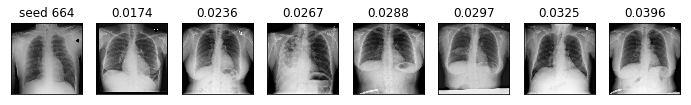

seed(664) labels: ['Atelectasis']
doc(3740) labels: ['Cardiomegaly']
doc(2174) labels: ['No Finding']
doc(1259) labels: ['Atelectasis', 'Mass']
doc(2120) labels: ['No Finding']
doc(258) labels: ['Mass']
doc(484) labels: ['Edema', 'Infiltration']
doc(4977) labels: ['No Finding']


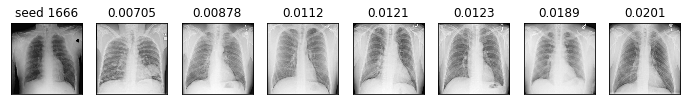

seed(1666) labels: ['No Finding']
doc(1415) labels: ['No Finding']
doc(748) labels: ['No Finding']
doc(3390) labels: ['No Finding']
doc(3680) labels: ['No Finding']
doc(1897) labels: ['Edema', 'Effusion']
doc(4267) labels: ['No Finding']
doc(1766) labels: ['Nodule']


In [49]:
for seed in documents[:4]:
    def score(doc):
        if doc['id'] == seed['id']:
            return np.inf
        else:
            return distance_matrix[seed['id'], doc['id']]

    results = heapq.nsmallest(7, documents, key=score)
    
    labels = []
    labels.append("seed({}) labels: {}".format(seed['id'], getlabels(seed)))
    
    fig, axes = plt.subplots(1, 8, figsize=(12, 2), subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0].set_title("seed {}".format(seed['id']))
    path = os.path.join(ORIGINAL_IMAGES_DIR, doc['filename'])
    img = mpimg.imread(path)
    axes[0].imshow(img, cmap='gray')
    
    for k in range(1, len(axes)):
        axes[k].set_title("{:.3g}".format(score(results[k-1])))
        path = os.path.join(ORIGINAL_IMAGES_DIR, results[k-1]['filename'])
        img = mpimg.imread(path)
        axes[k].imshow(img, cmap='gray')
    
    for i,result in enumerate(results): 
        labels.append("doc({}) labels: {}".format(result['id'], getlabels(result)))
        
    plt.show()
    
    for label in labels:
        print(label)


# Examine Embeddings

## Label Statistics

In [50]:
def label_percentage(label, dataset):
    
    dataset_size = len(dataset)
    
    count = 0
    for doc in dataset:
        if(label in getlabels(doc)):
            count += 1 
            
    return count/dataset_size

In [51]:
for label in LABEL_KEYS:
    percentage = label_percentage(label, documents)
    print("{:<20s} {}".format(label,percentage))

Atelectasis          0.08849384645438563
Cardiomegaly         0.029888650126977924
Consolidation        0.03360031256104708
Edema                0.010353584684508694
Effusion             0.08419613205704239
Emphysema            0.023051377222113693
Fibrosis             0.020121117405743308
Hernia               0.0013674545809728462
Infiltration         0.13694080875170933
Mass                 0.04121898808361008
Nodule               0.04668880640750146
No Finding           0.5958194959953116
Pleural_Thickening   0.03027935143582731
Pneumonia            0.010548935338933385
Pneumothorax         0.04551670248095331


## Neighbors Accuracy

In [52]:
QUERY_NUMBER = 100
k = 20
mu_embeddings = []
for doc in documents:
        mu_embeddings.append(doc['mu'].tolist())

In [53]:
def build_similarities(query_id, vectors):
    ''' suppose vectors[i, :] is a single vector in your set;
        that is, vectors is a numpy array, where each row is normalized
        to l2-norm=1
        
        returns a numpy vector of similarities: the i'th entry is the similarity
        between the i'the vector and the query_id vector
    '''
    return vectors.dot(vectors[query_id])

In [54]:
'''calculate k nearest vectors of a query vector.'''
def calculate_knearest(query_id, vectors, k):

    vectors = np.array(vectors, dtype=np.float)  
    scores_truth = build_similarities(query_id, vectors)
    topk_truth = heapq.nlargest(k, list(enumerate(scores_truth)), key = operator.itemgetter(1))
        
    return topk_truth

In [55]:
'''calculate average number of same labels in the k nearest neighbors over QUERY_NUMBER of samples.'''

def neighbor_labels_accuracy(embedding_vecs, k):

    np.random.seed(RANDOM_SEED)
    sample_vecs_index = np.random.choice(len(embedding_vecs), QUERY_NUMBER)
    avg = 0
    avg_per_sample = 0
    for i in range(QUERY_NUMBER):

        count = 0
        topk_neighbors = calculate_knearest(sample_vecs_index[i], embedding_vecs, k)  
        topk_neighbors_indexes = [x[0] for x in topk_neighbors]
        query_labels = getlabels(documents[sample_vecs_index[i]])

        for j,query_label in enumerate(query_labels):
            for neighbor_index in topk_neighbors_indexes:
                if query_label in getlabels(documents[neighbor_index]):
                    count += 1

        avg_per_sample += count/(j+1)

    avg =  avg_per_sample/QUERY_NUMBER 
    return avg

In [56]:
neighbor_labels_accuracy(mu_embeddings, k)

9.568333333333333

In [57]:
QUERY_NUMBER = 100
def conditional_neighbor_labels_accuracy(conditional_label, embedding_vecs, k):

    np.random.seed(RANDOM_SEED)
    sample_vecs_index = []
    avg = 0
    avg_per_sample = 0
    
    while True:
        trial_index = np.random.randint(0,len(embedding_vecs))
        if conditional_label in getlabels(documents[trial_index]):
            sample_vecs_index.append(trial_index)
        if len(sample_vecs_index) == QUERY_NUMBER:
            break
    
    results = []
    for i in range(QUERY_NUMBER):
    
        count = 0

        topk_neighbors = calculate_knearest(sample_vecs_index[i], embedding_vecs, k)  
        topk_neighbors_indexes = [x[0] for x in topk_neighbors]
        query_labels = getlabels(documents[sample_vecs_index[i]])

        
        for neighbor_index in topk_neighbors_indexes:
            if conditional_label in getlabels(documents[neighbor_index]):
                count += 1
        results.append(count) 
     
    return results

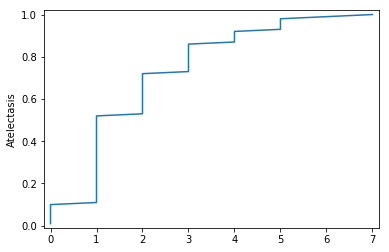

Percentage           8.849384645438562


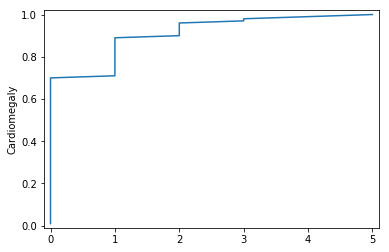

Percentage           2.9888650126977923


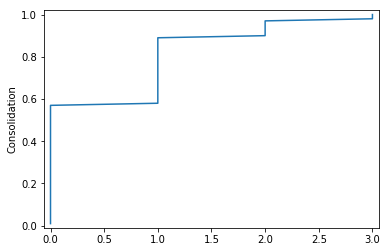

Percentage           3.360031256104708


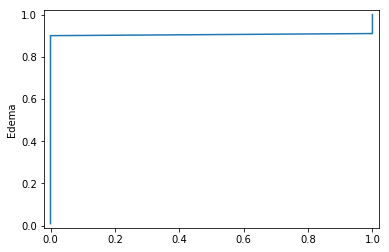

Percentage           1.0353584684508694


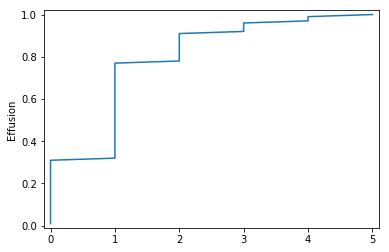

Percentage           8.41961320570424


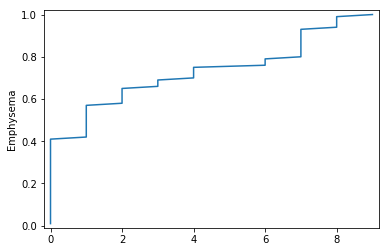

Percentage           2.305137722211369


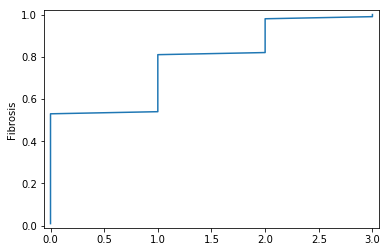

Percentage           2.0121117405743307


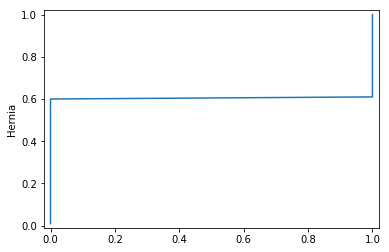

Percentage           0.1367454580972846


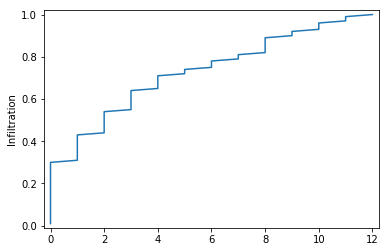

Percentage           13.694080875170933


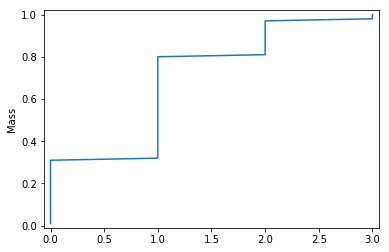

Percentage           4.121898808361008


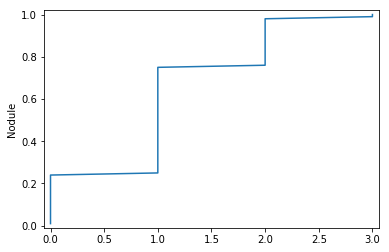

Percentage           4.668880640750146


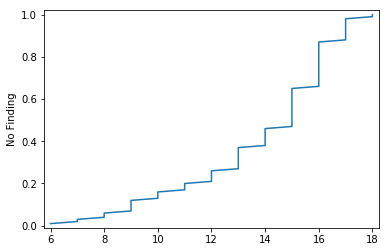

Percentage           59.58194959953116


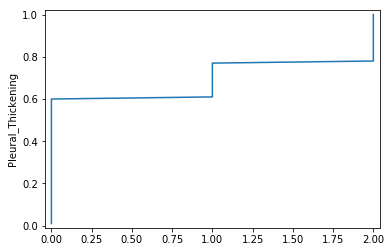

Percentage           3.0279351435827313


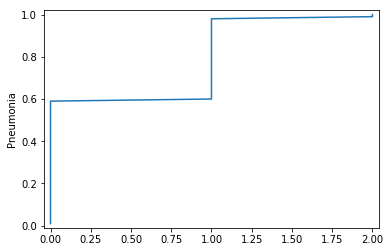

Percentage           1.0548935338933385


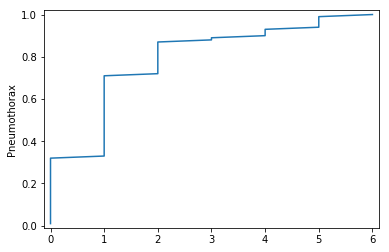

Percentage           4.5516702480953315


In [58]:
for label in LABEL_KEYS:
    x = np.sort(conditional_neighbor_labels_accuracy(label, mu_embeddings, k))
    y = np.arange(1,len(x)+1) / len(x)
    _ = plt.plot(x,y)
    _ = plt.ylabel(label)
    plt.margins(0.02)
    plt.show()
    percentage = label_percentage(label, documents)
    print("{:<20s} {}".format("Percentage",100*percentage))

# Visualisation

In [67]:
from collections import OrderedDict
LABEL_KEYS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
    "No Finding", 
]

label_keys_by_id = LABEL_KEYS
ids_by_label_key_radiologist = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id)])
  
def getlabels(onehot_labels):
    list = []
    for index_value, index in enumerate(onehot_labels):
        if(index == 1):
            list.append(ids_by_label_key_radiologist.get(index_value))

    return list

In [60]:
from collections import OrderedDict
LABEL_KEYS_SHORT = [
    "Ats",
    "Ca",
    "Co",
    "Ed",
    "Ef",
    "Em",
    "Fi",
    "He",
    "In",
    "Ma",
    "No",
    "No",
    "Pl",
    "Pn",
    "Px"
]

label_keys_by_id2 = LABEL_KEYS_SHORT
ids_by_label_key2 = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id2)])

def getlabels_short(doc):
    list = []
    for index_value, index in enumerate(doc['labels']):
        if(index == 1):
            list.append(ids_by_label_key2.get(index_value)[:2])
            
    return list

In [62]:
from skimage.color import rgb2gray

#generate a sprite image consisting of all the images
def create_sprite_image(documents, directory):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    
    images = []
    for doc in documents:
        path = os.path.join(ORIGINAL_IMAGES_DIR, doc['filename'])
        img = mpimg.imread(path)
        if len(np.shape(img)) == 3:
            img = rgb2gray(img)
        
        images.append(img)

    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
                
    plt.imsave(directory, spriteimage, cmap='gray')
    plt.imshow(spriteimage,cmap='gray')
    
    return spriteimage

In [63]:
#generate a metadata consisting of index and label of our embedding vectors
#The Index is simply the index in our embedding matrix. The label is a string of a patient's diseases.
def create_metadata(documents, directory):
    
    with open(directory,'w') as f:
        f.write("Index\tLabels\tFirst_label\n")
        for index,doc in enumerate(documents):
            f.write("%d\t%s\t%s\n" % (index, getlabels_short(doc), getlabels(doc)[0]))

In [68]:
sprite_image = create_sprite_image(documents[:100], SPRITE_DIR)
metadata = create_metadata(documents[:100], META_DIR)

KeyboardInterrupt: 

In [ ]:
#feed embedding variables into feed into the visualizer
mu_embedding = []
sigma_embedding = []
embeddings = []
embedding_names = []

for doc in documents:
        mu_embedding.append(doc['mu'].tolist())
embeddings.append(mu_embedding)
embedding_names.append('mu')

for doc in documents:
        sigma_embedding.append(doc['sigma'].tolist())
embeddings.append(sigma_embedding)
embedding_names.append('sigma')

In [ ]:
#specify what variable you want to project, what the metadata path is (the names and classes),
#and where you save the sprites
summary_writer = tf.summary.FileWriter(VIS_DIR)
config = projector.ProjectorConfig()

for i,e in enumerate(embeddings):
    
    embedding_var = tf.Variable(e, name=embedding_names[i])
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # Specify where you find the metadata
    embedding.metadata_path = 'metadata.tsv' #'metadata.tsv'

    # Specify where you find the sprite (we will create this later)
    embedding.sprite.image_path = 'sprite.png' #'sprite.png'
    embedding.sprite.single_image_dim.extend([256,256])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [ ]:
#Tensorboard loads the saved variable from the saved graph. 
#Initialise a session and variables, and save them in your logging directory.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join("model1.ckpt"), 1)